Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

acc:0.571, loss:1.423, training:True
acc:0.642, loss:1.114, training:True
acc:0.679, loss:0.976, training:True
acc:0.682, loss:0.961, training:False
{'accuracy': '0.608', 'loss': '1.363', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.691', 'loss': '0.887', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.718', 'loss': '0.791', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.749', 'loss': '0.728', 'epoch': 1, 'train': 'eval'}
{'accuracy': '0.764', 'loss': '0.685', 'epoch': 2, 'train': 'train'}
{'accuracy': '0.769', 'loss': '0.669', 'epoch': 2, 'train': 'eval'}


accuracy,loss,epoch,train
0.629,1.115,0,train
0.667,0.925,0,eval


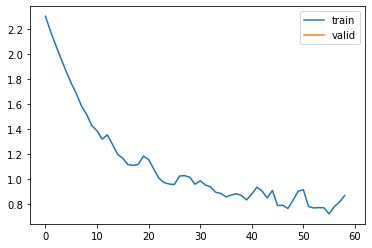

accuracy,loss,epoch,train
0.662,0.955,0,train
0.755,0.633,0,eval


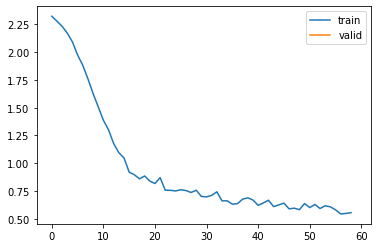

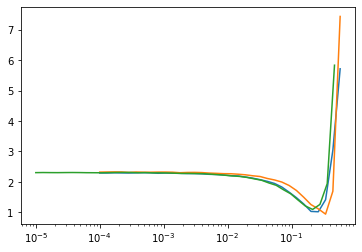

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, default_collate
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import partial
import fastcore.all as fc
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from operator import itemgetter, attrgetter
import torch.optim as optim
from functools import partial
from copy import copy
from torcheval.metrics import MulticlassAccuracy, Mean
from fastprogress import master_bar, progress_bar
from miniai.lec_9_v4 import *

In [118]:
x,y = 'image','label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [119]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

def collate_dict(ds):
    g = itemgetter(*ds.features)
    def _f(b):
        return g(default_collate(b))
    return _f

def get_dls(train_ds, valid_ds, batch_size, **kwargs):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, **kwargs),
    )

@inplace
def transformi(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    
class DataLoaders:
    def __init__(self, *ds):
        self.train,self.valid = ds[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train']) 
        return cls(*get_dls(*dd.values(), batch_size=batch_size, collate_fn=f, **kwargs))

In [120]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs)

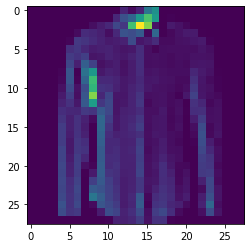

In [29]:
plt.imshow(next(iter(dls.train))[0][0][0])

In [49]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(*[res, nn.ReLU()])
    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5), # 14x14
        conv(8, 16), # 7x7
        conv(16, 32), # 4x4
        conv(32, 64), # 2x2
        conv(64, 10, act=False), # 1x1
        nn.Flatten()
    ]

In [35]:
import math
def output_volume(w, f, k, p, s):
    return math.floor(((w-k+2*p)/s) + 1)

In [44]:
w,f,k,p,s = 28,8,5,5//2,2
w,f,k,p,s = 14,16,3,3//2,2
w,f,k,p,s = 7,32,3,3//2,2
w,f,k,p,s = 4,64,3,3//2,2
w,f,k,p,s = 2,10,3,3//2,2

In [45]:
output_volume(w, f, k, p, s)

1

accuracy,loss,epoch,train
0.163,2.361,0,train
0.100,2.317,0,eval


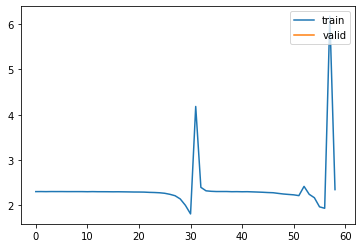

In [121]:
from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainerCB(1), metrics, ProgressCB(plot=True)]

def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, copy(dls), loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

learn = fit(nn.Sequential(*cnn_layers()))

accuracy,loss,epoch,train
0.160,2.282,0,train
0.281,1.910,0,eval


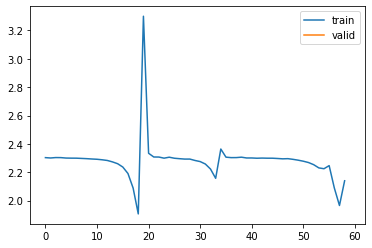

In [56]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
    
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.detach().mean())
            self.act_stds[i].append(x.detach().std())       
        return x
    
    def __iter__(self):
        return iter(self.layers)
    
model = SequentialModel(*cnn_layers())
learn = fit(model)

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

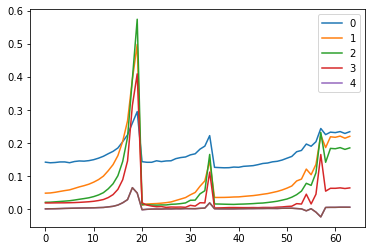

In [58]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(5))

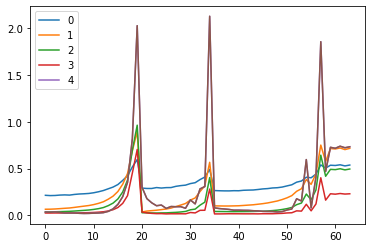

In [59]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(5))

In [63]:
model = nn.Sequential(*cnn_layers())
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.detach().mean())
    act_stds[i].append(outp.detach().std())  

for i,m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.138,2.316,0,train
0.225,2.292,0,eval


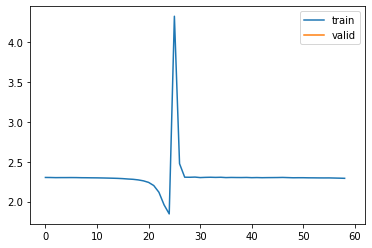

In [64]:
fit(model)

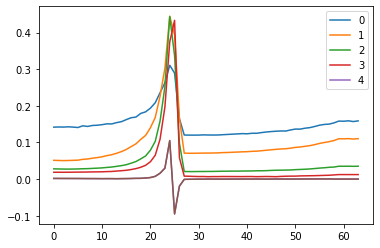

In [65]:
for l in act_means:
    plt.plot(l)
plt.legend(range(5))

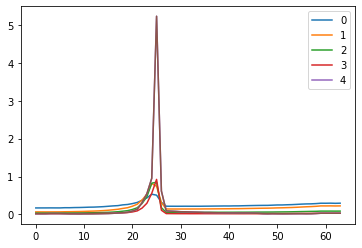

In [66]:
for l in act_stds:
    plt.plot(l)
plt.legend(range(5))

In [73]:
class Hook:
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    
    def remove(self):
        self.hook.remove()
    
    def __del__(self):
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = [],[]
    acts = outp.detach()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

model = nn.Sequential(*cnn_layers())
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.152,2.319,0,train
0.100,2.302,0,eval


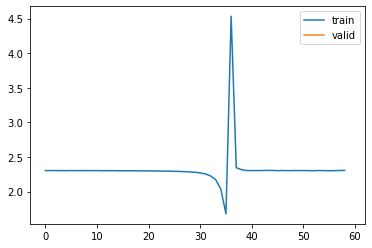

In [74]:
learn = fit(model)

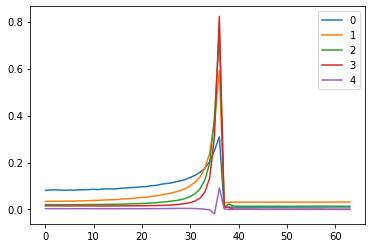

In [75]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

In [79]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    
    def __exit__(self, *args):
        print("all done!")
    
    def hello(self):
        print('hello.')

In [80]:
with DummyCtxMgr() as dcm: 
    dcm.hello()

let's go!
hello.
all done!


In [87]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)
        
dml = DummyList([1, 2, 3])
del(dml[2])
dml

Say bye to item 2


[1, 2]

accuracy,loss,epoch,train
0.125,2.410,0,train
0.100,2.303,0,eval


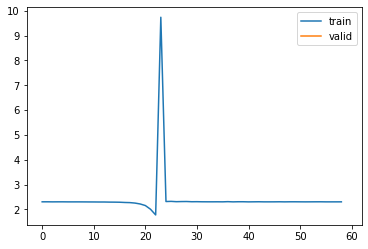

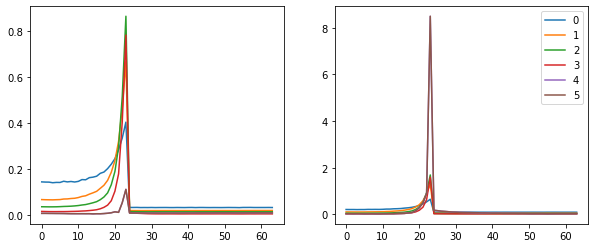

In [90]:
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
    
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    
    def remove(self):
        for h in self:
            h.remove()

model = nn.Sequential(*cnn_layers())

with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6))

accuracy,loss,epoch,train
0.168,2.256,0,train
0.191,2.275,0,eval


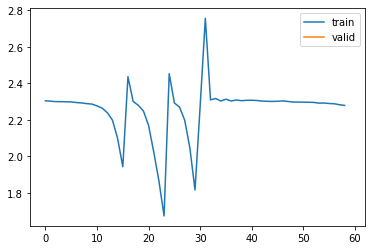

In [97]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter())
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
    
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)
    
    def after_fit(self, learn):
        self.hooks.remove()
    
    def __iter__(self):
        return iter(self.hooks)
    
    def __len__(self):
        return len(self.hooks)

hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc])

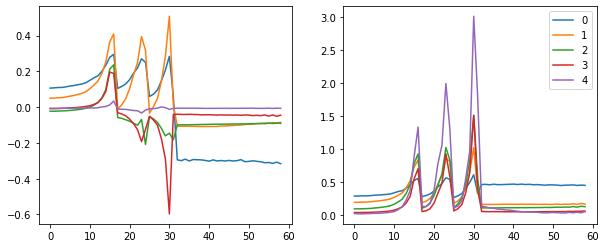

In [98]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1:
        axs[i].plot(h.stats[i])
plt.legend(range(6))

In [123]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    acts = outp.detach()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.222,2.198,0,train
0.403,1.835,0,eval


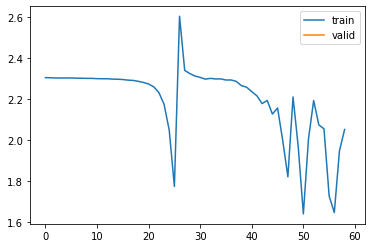

In [124]:
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [126]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

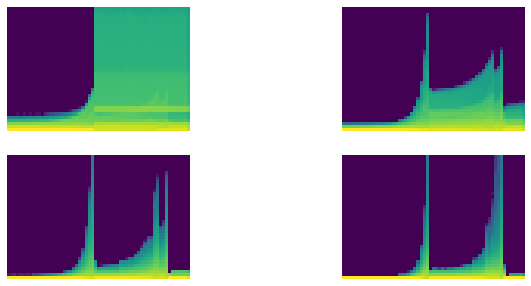

In [134]:
import numpy as np

fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [133]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs